# Babu's Artificial Neural Network

In this notebook I will provide a step by step multi layer perceptron (artificial neural network) implementation using only basic python and numpy. Other libraries will be used for auxiliary tasks such as data visualization and manipulation.

The multi layer perceptron will be build using a layererd structure which provides modularity and possibilities for expansion.

## Adding the necessary imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Defining the layered structure

The network will be comprised of two fundamental types of layers: linear layers and activation functions.

Each layer will implement an interface that permits forward passing and back propagation.

### The layer interface

In [23]:
from abc import ABC, abstractmethod

class Layer:
    @abstractmethod
    def forward(self,x):
        return
    @abstractmethod
    def backward(self,dupstream):
        return

### Concrete layer implementations

#### Linear Layers

At the core of the neural network, there are linear layers. Each linear layer applies a linear transformation to the input data, consisting of two main operations: the weighted sum of inputs and the addition of a bias term.

In [24]:
class LinearLayer(Layer):
    def __init__(self, in_features, out_features, init_strategy):
        """Initialize the weights and biases of the linear layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.
            init_strategy (callable): Weight initialization strategy function.
        """
        # Initialize weights and biases
        weight_shape = (out_features, in_features)
        bias_shape = (out_features, 1)
        self.weight, self.bias = init_strategy(weight_shape, bias_shape, in_features)

        self.cache = None  # Cache for storing the input during forward pass
        self.weight_grad = None  # Gradient of loss w.r.t. weights
        self.bias_grad = None  # Gradient of loss w.r.t. biases

    def forward(self, x):
        """Perform the forward pass of a linear layer.

        Args:
            x (numpy.ndarray): Input to the linear layer.

        Returns:
            numpy.ndarray: Output of the linear layer.
        """
        # Calculate output by matrix multiplication with weights and adding biases
        output = np.dot(self.weight, x.T) + self.bias
        self.cache = x  # Cache the input for backward pass
        return output.T  # Transpose the output to match the shape of input x

    def backward(self, dupstream):
        """Perform the backward pass of a linear layer.

        Args:
            dupstream (numpy.ndarray): Upstream gradient.

        Returns:
            numpy.ndarray: Downstream gradient.
        """
        # Calculate gradients
        self.weight_grad = np.dot(dupstream.T, self.cache)
        self.bias_grad = np.sum(dupstream, axis=0, keepdims=True).T

        # Calculate downstream gradient
        dx = np.dot(dupstream, self.weight)
        return dx


#### Weight initialization

In [25]:
def Gaussian_Init(weight_sizes, bias_sizes, n_neurons = -1):
    return np.random.normal(size = weight_sizes), np.random.normal(size = bias_sizes)

def Uniform_Init(weight_sizes, bias_sizes, n_neurons = -1):
    return np.random.uniform(size=weight_sizes, low= -1, high= 1),np.random.uniform(size= bias_sizes, low= -1, high= 1)

#### Activation Layers

Following the linear layer, there's an activation layer which introduces non-linearity to the network. This layer applies a non-linear activation function element-wise to the outputs of the linear layer.

Multiple activation functions are provided: Sigmoid, ReLU and SoftMax.

In [26]:
import numpy as np

class ActivationSigmoidLayer(Layer):
    def __init__(self):
        """Initialize a sigmoid activation layer."""
        self.cache = None
    
    def forward(self, x):
        """Perform a forward pass with a sigmoid activation function.
        
        Args:
            x (numpy.ndarray): Input to the activation function.

        Returns:
            numpy.ndarray: Output of the activation function.
        """
        y = 1 / (1 + np.exp(-x))
        self.cache = y
        return y
        
    def backward(self, dupstream): 
        """Perform a backward pass of the sigmoid activation function.
        
        Args:
            dupstream (numpy.ndarray): Upstream gradient.

        Returns:
            numpy.ndarray: Downstream gradient.
        """
        grad = self.cache * (1 - self.cache)
        return grad * dupstream

class ActivationReLULayer(Layer):
    def __init__(self):
        """Initialize a ReLU activation layer."""
        self.cache = None
    
    def forward(self, x):
        """Perform a forward pass with a ReLU activation function.
        
        Args:
            x (numpy.ndarray): Input to the activation function.

        Returns:
            numpy.ndarray: Output of the activation function.
        """
        y = np.maximum(0, x)
        self.cache = x
        return y
        
    def backward(self, dupstream): 
        """Perform a backward pass of the ReLU activation function.
        
        Args:
            dupstream (numpy.ndarray): Upstream gradient.

        Returns:
            numpy.ndarray: Downstream gradient.
        """
        return (self.cache > 0) * dupstream

class ActivationSoftMaxLayer(Layer):
    def __init__(self):
        """Initialize a softmax activation layer."""
        self.cache = None
    
    def forward(self, x):
        """Perform a forward pass with a softmax activation function.
        
        Args:
            x (numpy.ndarray): Input to the activation function.

        Returns:
            numpy.ndarray: Output of the activation function.
        """
        exp = np.exp(x)
        divider = np.sum(exp, axis=1, keepdims=True)
        y = exp / divider
        self.cache = y
        return y
        
    def backward(self, dupstream): 
        """Perform a backward pass of the softmax activation function.
        
        Args:
            dupstream (numpy.ndarray): Upstream gradient.

        Returns:
            numpy.ndarray: Downstream gradient.
        """
        batch_size = dupstream.shape[0]
        output_size = self.cache.shape[1]
        dx = np.zeros_like(dupstream)

        for i in range(batch_size):
            # Compute Jacobian matrix for each sample in the batch
            jac = np.diag(self.cache[i]) - np.outer(self.cache[i], self.cache[i])
            # Backpropagate the gradient for each sample
            dx[i] = np.dot(dupstream[i], jac)
        
        return dx


## Network Implementation

In [27]:
class Network:
    def __init__(self, layers, input_size, output_size):
        """Initialize the neural network.

        Args:
            layers (list): List of layers in the network.
            input_size (int): Size of the input data.
            output_size (int): Size of the output predictions.
        """
        self.layers = layers
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, x):
        """Perform a forward pass over the entire network.

        Args:
            x (numpy.ndarray): Input data.

        Returns:
            numpy.ndarray: Predictions.
        """
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, dupstream):
        """Perform a backward pass over the entire network.

        Args:
            dupstream (numpy.ndarray): Upstream gradient.

        Returns:
            numpy.ndarray: Downstream gradient.
        """
        gradient = dupstream
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def optimizer_step(self, lr):
        """Update the weight and bias parameters of each layer using gradient descent.

        Args:
            lr (float): Learning rate.
        """
        for layer in self.layers:
            if isinstance(layer, LinearLayer):
                layer.weight -= lr * layer.weight_grad
                layer.bias -= lr * layer.bias_grad

                # Reset cache and gradients
                layer.cache = None
                layer.weight_grad = None
                layer.bias_grad = None


#### Network configuration

At the moment the network is initialized with a list of Layers. To create these layers following a certaing specification the Network_Config class is provided.

In [28]:
class NetworkConfig:
    def __init__(self, n_input, h_structure, n_output, h_activation, o_activation, init_function):
        """Initialize the configuration for a neural network.

        Args:
            n_input (int): Number of input neurons.
            h_structure (list): List specifying the structure of hidden layers.
            n_output (int): Number of output neurons.
            h_activation (Activation): Activation function for hidden layers.
            o_activation (Activation): Activation function for output layer.
            init_function: Initialization strategy for linear layers.
        """
        self.n_input = n_input
        self.h_structure = h_structure
        self.n_output = n_output
        self.h_activation = h_activation
        self.o_activation = o_activation
        self.init_function = init_function
    
    def create_layers(self):
        """Create layers for a neural network model.

        Returns:
            list: List of layers for the neural network model.
        """
        if len(self.h_structure) == 0:
            return [LinearLayer(self.n_input, self.n_output, self.init_function), self.o_activation]

        # Initialize input and output linear layers
        input_linear_layer = LinearLayer(self.n_input, self.h_structure[0], self.init_function)
        output_linear_layer = LinearLayer(self.h_structure[-1], self.n_output, self.init_function)

        # Initialize layers list with input layers
        layers = [input_linear_layer, self.h_activation()]

        # Create hidden layers
        for i in range(1, len(self.h_structure)):
            layers.append(LinearLayer(self.h_structure[i - 1], self.h_structure[i], self.init_function))
            layers.append(self.h_activation())

        # Add output linear layer and activation function
        layers.append(output_linear_layer)
        layers.append(self.o_activation())

        return layers


#### Loss function

The network needs a loss function. I have implemented categorical cross entropy (for now).

This is needed going forward since I plan to use the network for a classification task.

In [29]:
def Categorical_Cross_Entropy_Loss(y_true, y_pred):
    """Compute the value of the categorical cross-entropy loss function and its gradient.

    Args:
        y_true (numpy.ndarray): Ground truth labels.
        y_pred (numpy.ndarray): Predicted labels.

    Returns:
        tuple: A tuple containing the value of the loss and its gradient.
    """
    # Calculate the value of the loss
    loss = -np.sum(y_true * np.log(y_pred + 1e-8), axis=1)

    # Calculate the gradient of the loss with respect to the predictions
    grad = -y_true / (y_pred + 1e-8)

    return loss, grad

def Mean_Squared_Error_Loss(y_true, y_pred):
    """Compute the value of the mean squared error (MSE) loss function and its gradient.

    Args:
        y_true (numpy.ndarray): Ground truth labels.
        y_pred (numpy.ndarray): Predicted labels.

    Returns:
        tuple: A tuple containing the value of the loss and its gradient.
    """
    # Calculate the value of the loss
    loss = np.mean((y_true - y_pred)**2, axis=1)

    # Calculate the gradient of the loss with respect to the predictions
    grad = -2 * (y_true - y_pred)

    return loss, grad



#### Converting the network output to labels


The output of the network is an array corresponding to the probabilities of each label for a given input, while labels are numbers. We will provide a way to convert between these formats.

In [30]:
def label_to_net_format(label, n_labels):
    """Convert a label to the same format as the network output.

    Args:
        label (int): The label to be converted.
        n_labels (int): Total number of labels.

    Returns:
        numpy.ndarray: An array representing the label in the same format as the network output.
    """
    expected = np.zeros(shape=(1,n_labels))
    expected[0,int(label)] = 1
    return expected

def net_format_to_label(arr):
    """Convert the output format of the network to a label.

    Args:
        arr (numpy.ndarray): The array to be converted.

    Returns:
        int: The label corresponding to the array.
    """
    return np.argmax(arr)


#### Getting predictions

In [31]:
def predict(network, data):
    """Classify data entries using the provided neural network.

    Args:
        network (Network): The trained neural network.
        data (numpy.ndarray): The data to be classified.

    Returns:
        list: A list of classifications for each data entry.
    """
    classifications = []
    for entry in data:
        # Reshape data entry to match the input size of the network
        entry = np.reshape(entry, (1, network.input_size))
        
        # Forward pass through the network to obtain predictions
        predictions = network.forward(entry)
        
        # Convert network output format to label
        label = net_format_to_label(predictions)
        
        # Append the classification to the list
        classifications.append(label)
        
    return classifications


#### Testing classifications

In [32]:
def evaluate_test_set(network, test_features, test_labels, loss_criterion):
    """Evaluate the performance of the network on a test set.

    Args:
        network (Network): The neural network model.
        test_features (numpy.ndarray): Input features of the test set.
        test_labels (numpy.ndarray): Target labels of the test set.
        loss_criterion (callable): Loss function.

    Returns:
        tuple: A tuple containing lists of individual loss and accuracy for each entry in the test set.
    """
    # Ensure test_features and test_labels are numpy arrays
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    # Initialize lists to store losses and accuracies for each sample
    losses = []
    accuracies = []

    # Loop through each sample in the test set
    for sample,label in zip(test_features,test_labels):
        sample = np.reshape(sample,(1,len(sample)))
        # Forward pass to get prediction for the current sample
        prediction = network.forward(sample)
    
        # Create the expected output
        expected = label_to_net_format(label,network.output_size)
        # Compute loss for the current sample
        sample_loss, _ = loss_criterion(expected, prediction)

        # Compute accuracy for the current sample
        predicted_label = net_format_to_label(prediction)
        sample_accuracy = 1 if predicted_label == label else 0

        # Append loss and accuracy for the current sample to the lists
        losses.append(sample_loss)
        accuracies.append(sample_accuracy)

    return losses,accuracies

## Training Process
The training process comprises the following steps for each iteration of optimization:

- Utilize a forward pass of the network to generate predictions.

- Compute the loss and its gradient by comparing the predictions with the ground truth using the selected criterion.

- Execute a backward pass of the network to compute gradients.

- Update all parameters of the network.

Two methods for training the model are provided: Stochastic Gradient Descent and Mini-Batch Gradient Descent.

In [33]:
def train_with_SGD(network, inputs, labels, loss_function, learning_rate):
    """Train the neural network using Stochastic Gradient Descent (SGD).

    Args:
        network: The neural network model.
        inputs: Input data.
        labels: Target labels.
        loss_function: Loss function.
        learning_rate: Learning rate.

    Returns:
        tuple: A tuple containing lists of losses and accuracies at each optimizer step.
    """
    # Generate shuffled indices
    num_samples = len(inputs)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    inputs = inputs[indices]
    labels = labels[indices]

    losses = []
    accuracies = []

    for input_data, label in zip(inputs, labels):
        # Reshape input data to match network input size
        input_data = np.reshape(input_data, (1, len(input_data)))
        
        # Forward pass
        output = network.forward(input_data)
        
        # Create the expected output
        expected_output = label_to_net_format(label, len(output))

        # Compute loss and gradient
        loss, gradient = loss_function(expected_output, output)
        
        # Backward pass
        network.backward(gradient)
        
        # Optimizer step
        network.optimizer_step(learning_rate)
        
        # Compute accuracy 
        predicted_label = net_format_to_label(output)
        accuracy = 1 if predicted_label == label else 0
        
        # Append loss and accuracy to lists
        losses.append(loss)
        accuracies.append(accuracy)
    
    return losses, accuracies


def train_with_MBGD(network, inputs, labels, loss_function, learning_rate, batch_size):
    """Train the neural network using Mini-Batch Gradient Descent (MBGD).

    Args:
        network: The neural network model.
        inputs: Input data.
        labels: Target labels.
        loss_function: Loss function.
        learning_rate: Learning rate.
        batch_size: Batch size.

    Returns:
        tuple: A tuple containing lists of losses and accuracies at each optimizer step.
    """
    num_samples = len(inputs)
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    # Generate shuffled indices
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    inputs = inputs[indices]
    labels = labels[indices]

    losses = []
    accuracies = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        batch_inputs = inputs[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Forward pass
        output = network.forward(batch_inputs)

        # Compute loss and gradient for the batch
        expected_output = np.zeros_like(output)
        for i, label in enumerate(batch_labels):
            expected_output[i, int(label)] = 1

        loss, gradient = loss_function(expected_output, output)

        # Backward pass
        network.backward(gradient)

        # Optimizer step
        network.optimizer_step(learning_rate)

        # Compute accuracy for the batch
        predicted_labels = np.argmax(output, axis=1)
        accuracy = np.mean(predicted_labels == batch_labels)
        accuracies.append(accuracy)

        # Append loss to the list
        losses.append(np.mean(loss))

    return losses, accuracies


In [34]:
def train_SGD_for_iterations(net, inputs, labels, criterion, lr, iters):
    """
    Train a neural network using Stochastic Gradient Descent (SGD) for a specified number of iterations.

    Args:
        network (Network): The neural network to be trained.
        inputs (numpy.ndarray): Input features.
        labels (numpy.ndarray): Target labels.
        loss_function (callable): Loss function.
        learning_rate (float): Learning rate.
        iterations (int): Number of iterations.

    Returns:
        tuple: A tuple containing lists of losses and accuracies over the training iterations.
    """
    losses = []
    accuracies = []
    # Iterate through epochs
    for epoch in range(iters):

        # Train model
        epoch_losses,epoch_accuracies = train_with_SGD(net,inputs,labels,criterion,lr)

        # Save statistics
        losses.append(np.mean(epoch_losses))
        accuracies.append(np.mean(epoch_accuracies))
        
    
    return losses, accuracies

def train_SGD_with_early_stopping_threshold(net, inputs, labels,val_inputs, val_labels, criterion, lr, epochs, stop_thresh = 1e-10):
    """
    Train a neural network using SGD with early stopping based on a threshold for change in accuracy.

    Args:
        network (Network): The neural network to be trained.
        inputs (numpy.ndarray): Input features for training.
        labels (numpy.ndarray): Target labels for training.
        val_inputs (numpy.ndarray): Input features for validation.
        val_labels (numpy.ndarray): Target labels for validation.
        loss_function (callable): Loss function.
        learning_rate (float): Learning rate.
        epochs (int): Maximum number of epochs to train.
        stop_threshold (float, optional): Threshold for change in accuracy to stop training early. Defaults to 1e-10.

    Returns:
        tuple: A tuple containing lists of losses and accuracies over the training iterations, and losses and accuracies over the validation set.
    """
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    # Iterate through epochs
    for epoch in range(epochs):

        # Train model and compute validation loss/accuracy
        epoch_losses,epoch_accuracies = train_with_SGD(net,inputs,labels,criterion,lr)
        epoch_test_losses, epoch_test_accuracies = evaluate_test_set(net,val_inputs,val_labels,criterion)

        # Save statistics
        losses.append(np.mean(epoch_losses))
        accuracies.append(np.mean(epoch_accuracies))
        val_losses.append(np.mean(epoch_test_losses))
        val_accuracies.append(np.mean(epoch_test_accuracies))

        # Check if improvement is too small
        if(epoch > 1 and np.abs(val_losses[-2] - val_losses [-1]) < stop_thresh):
            break
    
    return losses, accuracies, val_losses, val_accuracies

def train_SGD_with_early_stopping_patience(net, inputs, labels,val_inputs, val_labels, criterion, lr, epochs, patience = 10):
    """
    Train a neural network using SGD with early stopping based on patience (number of epochs without improvement).

    Args:
        network (Network): The neural network to be trained.
        inputs (numpy.ndarray): Input features for training.
        labels (numpy.ndarray): Target labels for training.
        val_inputs (numpy.ndarray): Input features for validation.
        val_labels (numpy.ndarray): Target labels for validation.
        loss_function (callable): Loss function.
        learning_rate (float): Learning rate.
        epochs (int): Maximum number of epochs to train.
        patience (int, optional): Number of epochs to wait for improvement before early stopping. Defaults to 10.

    Returns:
        tuple: A tuple containing lists of losses and accuracies over the training iterations, and losses and accuracies over the validation set.
    """
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = float('-inf')
    epochs_without_improvement = 0

    # Iterate through epochs
    for epoch in range(epochs):
        
        # Train model and compute validation loss/accuracy
        epoch_losses, epoch_accuracies = train_with_SGD(net, inputs, labels, criterion, lr)
        epoch_val_losses, epoch_val_accuracies = evaluate_test_set(net, val_inputs, val_labels, criterion)

        # Save statistics
        losses.append(np.mean(epoch_losses))
        accuracies.append(np.mean(epoch_accuracies))
        val_loss = np.mean(epoch_val_losses)
        val_accuracy = np.mean(epoch_val_accuracies)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check when the last improvement was, stop if too long ago
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            break

    return losses, accuracies, val_losses, val_accuracies

In [35]:
def train_MBGD_for_iters(net, inputs, labels, criterion, lr, batch_size, iters):
    """Train a neural network using Mini-Batch Gradient Descent (MBGD) for a specified number of iterations.

    Args:
        network (Network): The neural network model.
        inputs (numpy.ndarray): Input data.
        labels (numpy.ndarray): Target labels.
        loss_function (callable): Loss function.
        learning_rate (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        iterations (int): Number of iterations.

    Returns:
        tuple: A tuple containing lists of losses and accuracies over the training iterations.
    """
    losses = []
    accuracies = []

    # Iterate through epochs
    for epoch in range(iters):

        # Train model
        epoch_losses, epoch_accuracies = train_with_MBGD(net, inputs, labels, criterion, lr, batch_size)

        # Save statistics
        losses.append(np.mean(epoch_losses))
        accuracies.append(np.mean(epoch_accuracies))

    return losses, accuracies


def train_MBGD_with_early_stopping_threshold(net, inputs, labels, val_inputs, val_labels, criterion, lr, batch_size, epochs,stop_thresh = 1e-10):
    """Train a neural network using Mini-Batch Gradient Descent (MBGD) with early stopping based on a threshold for change in accuracy.

    Args:
        network (Network): The neural network model.
        inputs (numpy.ndarray): Input data for training.
        labels (numpy.ndarray): Target labels for training.
        val_inputs (numpy.ndarray): Input data for validation.
        val_labels (numpy.ndarray): Target labels for validation.
        loss_function (callable): Loss function.
        learning_rate (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        epochs (int): Maximum number of epochs to train.
        stop_threshold (float, optional): Threshold for change in accuracy to stop training early. Defaults to 1e-10.

    Returns:
        tuple: A tuple containing lists of losses and accuracies over the training iterations, and losses and accuracies over the validation set.
    """
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    # Iterate through epochs
    for epoch in range(epochs):

        # Train model and compute validation loss/accuracy
        epoch_losses,epoch_accuracies = train_with_MBGD(net,inputs,labels,criterion,lr,batch_size)
        epoch_test_losses, epoch_test_accuracies = evaluate_test_set(net,val_inputs,val_labels,criterion)

        # Save statistics
        losses.append(np.mean(epoch_losses))
        accuracies.append(np.mean(epoch_accuracies))
        val_losses.append(np.mean(epoch_test_losses))
        val_accuracies.append(np.mean(epoch_test_accuracies))

        # Check if improvement is too small
        if(epoch > 1 and np.abs(val_losses[-2] - val_losses [-1]) < stop_thresh):
            break

    return losses, accuracies, val_losses, val_accuracies

def train_MBGD_with_early_stopping_patience(net, inputs, labels, val_inputs, val_labels, criterion, lr, batch_size, epochs, patience = 10):
    """Train a neural network using Mini-Batch Gradient Descent (MBGD) with early stopping based on patience (number of epochs without improvement).

    Args:
        network (Network): The neural network model.
        inputs (numpy.ndarray): Input data for training.
        labels (numpy.ndarray): Target labels for training.
        val_inputs (numpy.ndarray): Input data for validation.
        val_labels (numpy.ndarray): Target labels for validation.
        loss_function (callable): Loss function.
        learning_rate (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        epochs (int): Maximum number of epochs to train.
        patience (int, optional): Number of epochs to wait for improvement before early stopping. Defaults to 10.

    Returns:
        tuple: A tuple containing lists of losses and accuracies over the training iterations, and losses and accuracies over the validation set.
    """
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = float('-inf')
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Iterate through epochs
    for epoch in range(epochs):
        
        # Train model and compute validation loss/accuracy
        epoch_losses, epoch_accuracies = train_with_MBGD(net, inputs, labels, criterion, lr, batch_size)
        epoch_val_losses, epoch_val_accuracies = evaluate_test_set(net, val_inputs, val_labels, criterion)

        # Save statistics
        losses.append(np.mean(epoch_losses))
        accuracies.append(np.mean(epoch_accuracies))
        val_loss = np.mean(epoch_val_losses)
        val_accuracy = np.mean(epoch_val_accuracies)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check when the last improvement was, stop if too long ago
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            break

    return losses, accuracies, val_losses, val_accuracies


##### Early stopping

I decided to end the training based on early stopping criteria. Specifically, I monitor the validation loss or accuracy during training, and if it fails to improve or starts to deteriorate over a certain number of epochs, we halt the training process.

##### Justification:

Early Stopping: Ending training when the validation loss or accuracy plateaus or worsens helps prevent overfitting. Continuing training beyond this point may lead to the model memorizing the training data rather than learning meaningful patterns. Early stopping strikes a balance between maximizing performance and preventing overfitting, resulting in a more generalizable model.

## Hyper-parameter Optimization

Methods to do nested k-fold cross validation are provided. They are not included in the pipeline for now, since they are too slow. 

In [36]:
def k_fold_split(features, labels, k=10):
    """
    Split the features and labels into k folds for cross-validation.

    Args:
    features (numpy.ndarray): Input features.
    labels (numpy.ndarray): Target labels.
    k (int): Number of folds for cross-validation.

    Returns:
    list: A list containing tuples of (train_features, train_labels, val_features, val_labels) for each fold.
    """
    # Initialize an empty list to store the splits
    splits = []
    
    # Calculate the number of samples per fold
    num_samples_per_fold = len(features) // k
    
    # Shuffle the data to ensure randomness in the splits
    indices = np.random.permutation(len(features))
    features_shuffled = features[indices]
    labels_shuffled = labels[indices]
    
    # Split the data into k folds
    for i in range(k):
        # Calculate the start and end indices for the current fold
        start_index = i * num_samples_per_fold
        end_index = (i + 1) * num_samples_per_fold if i < k - 1 else len(features)
        
        # Extract the validation data for the current fold
        val_features = features_shuffled[start_index:end_index]
        val_labels = labels_shuffled[start_index:end_index]
        
        # Extract the training data by excluding the validation data
        train_features = np.concatenate([features_shuffled[:start_index], features_shuffled[end_index:]])
        train_labels = np.concatenate([labels_shuffled[:start_index], labels_shuffled[end_index:]])
        
        # Append the current split to the list of splits
        splits.append((train_features, train_labels, val_features, val_labels))
    
    return splits

def grid_search(data_splits, base_config, grid, loss_criterion):
    """
    Perform grid search for hyperparameter optimization.
    Determines the optimal hyperparameters by minimizing the loss on the validation set.

    Args:
    data_splits (List[(train_features, train_labels, validation_features, validation_labels)]): List of tuples containing train and validation data splits with corresponding labels.
    base_config (Network_Config): Base configuration for the neural network.
    grid (dict): Dictionary specifying the hyperparameter grid to search over.
    loss_criterion (callable): Loss function used for evaluation.

    Returns:
    statistics (dict): A dictionary containing the best hyperparameters, along with their corresponding training loss and accuracy,
        as well as the validation loss and accuracy. Additionally, it provides models with the  best performances
    """


    statistics = {
        "min_loss":None,
        "max_acc":None,
        "min_loss_hyper_params":None,
        "max_acc_hyper_params":None,
        "min_loss_model":None,
        "max_acc_model":None
    }
    best_val_loss = float('inf')
    best_val_acc = 0.0

    # Iterate through all hyperparameter configurations (if more hyperparameters are to be optimized add more nested loops)
    for lr in grid["lr"]:
        for h_layers in grid["h_layer_struct"]:
            # Update base configuration with current hyperparameters
            base_config.h_structure = h_layers
            # Create lists to save loss and acc for each split
            current_config_losses = []
            current_config_accs = []
            # Create a list to save the models trained in the split
            current_config_models = []
            # Iterate splits and generate statistics
            for train_features, train_labels, test_features, test_labels in data_splits:
                # Initialize network
                network = Network(base_config.create_layers(),base_config.n_input,base_config.n_output)

                # Train the network
                train_loss, train_acc, val_loss, val_acc = train_MBGD_with_early_stopping_patience(network,train_features,train_labels,test_features,test_labels,loss_criterion,lr,grid["batch_size"],grid["max_epochs"],5) #In case the training method is to be changed, change this line
    
                # Evaluate the network on the validation set, compute loss and accuracy
                eval_loss,eval_acc =  evaluate_test_set(network, test_features, test_labels, loss_criterion)

                # Sav the information for the split
                current_config_accs.append(np.mean(eval_acc))
                current_config_losses.append(np.mean(eval_loss))
                current_config_models.append(network)
            
            # Get configuration average loss and accuracy on the validation set
            avg_config_loss = np.mean(current_config_losses)
            avg_config_acc = np.mean(current_config_accs)

            # Check if current hyper param config is the best so far based on validation loss
            if avg_config_loss < best_val_loss:
                # Update information about best hyper param config for loss
                best_val_loss = avg_config_loss
                statistics["min_loss"] = best_val_loss
                statistics["min_loss_hyper_params"] = {"lr": lr, "h_layers": h_layers}
                # Save the average model for this config
                statistics["min_loss_model"] = current_config_models[np.argmin(current_config_losses)]
            
            # Check if current hyper param config is the best so far based on accuracy
            if avg_config_acc > best_val_acc:
                # Update information about best hyper param config for accuracy
                best_val_acc = avg_config_acc
                statistics["max_acc"] = best_val_acc
                statistics["max_acc_hyper_params"] = {"lr": lr, "h_layers": h_layers}
                # Save the average model for this config
                statistics["max_acc_model"] = current_config_models[np.argmax(current_config_accs)]
        
    return statistics

def nested_k_fold(inputs, labels, base_config, loss_criterion = Categorical_Cross_Entropy_Loss, k = 5, hyper_params = hyper_param_grid):
    """
    Perform nested k-fold cross-validation to optimize hyperparameters.

    Args:
    inputs (numpy.ndarray): Input features.
    labels (numpy.ndarray): Target labels.
    loss_criterion (callable): Loss function.
    k (int, optional): Number of folds for cross-validation. Defaults to 5.
    base_config (Network_Config, optional): Base configuration for the neural network. Defaults to a predefined configuration.
    hyper_params (dict, optional): Hyperparameter grid to search over. Defaults to a predefined grid.

    Returns:
    statistics: List of tuples, each containing statistics for a fold. Each tuple consists of:
        - The results of grid search (best hyperparameters, training loss, and accuracy) for the fold's training data.
        - The average test loss and accuracy obtained by evaluating the best model on the fold's test data.
    """
    # Get the outer loop splits
    outer_splits = k_fold_split(features=inputs,labels=labels, k=k)
    statistics = []

    # Iterate over train and test splits (outer loop)
    for o_train_features, o_train_labels, test_features, test_labels in outer_splits:
        # Get inner splits
        inner_splits = k_fold_split(features=o_train_features,labels=o_train_labels,k=k)

        # Inner "loop" is managed by the grid_search function
        inner_split_stats = grid_search(inner_splits, base_config, hyper_params, loss_criterion)

        # Evaluate the average model for the best configuration found in the inner split
        test_loss,test_acc = evaluate_test_set(inner_split_stats["max_acc_model"], test_features, test_labels, loss_criterion)

        # Save information
        statistics.append((inner_split_stats,np.mean(test_loss),np.mean(test_acc)))
        
    return statistics

def print_statistics(statistics):
    """
    Print the statistics obtained from nested k-fold cross-validation.

    Args:
    statistics (list): List containing tuples of statistics for each outer fold.

    Returns:
    None
    """
    best_accuracy = float('-inf')
    best_model_index = -1
    print("Statistics for Nested k-fold Cross-Validation:")
    print("==============================================\n")
    for i, (inner_stats, test_loss, test_acc) in enumerate(statistics):
        print(f"Fold {i + 1}:")
        print("----------------------")
        print("Hyperparameters for Minimum Validation Loss:")
        print("-------------------------------------------")
        print("Learning Rate:", inner_stats['min_loss_hyper_params']['lr'])
        print("Hidden Layers Structure:", inner_stats['min_loss_hyper_params']['h_layers'])
        print("Minimum Validation Loss:", inner_stats['min_loss'])
        print("\nHyperparameters for Maximum Validation Accuracy:")
        print("-----------------------------------------------")
        print("Learning Rate:", inner_stats['max_acc_hyper_params']['lr'])
        print("Hidden Layers Structure:", inner_stats['max_acc_hyper_params']['h_layers'])
        print("Maximum Validation Accuracy:", inner_stats['max_acc'])
        print("\nTest Set Statistics (for the best accuracy model):")
        print("--------------------")
        print("Average Test Loss:", test_loss)
        print("Average Test Accuracy:", test_acc)
        print("\n")

        # Check for best accuracy
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model_index = i

    print("Best Model by Accuracy:")
    print("------------------------")
    print(f"Fold {best_model_index + 1} has the highest accuracy of {best_accuracy}\n")

# Trying the MLP on the MNIST data set

## Training an MLP on the MNIST Dataset

In this notebook, we aim to demonstrate that our Multi-Layer Perceptron (MLP) implementation is functional and capable of learning and performing classification tasks on the MNIST dataset. The primary objective is to show that the model works rather than finding the optimal hyperparameters.

### 1. Prepare the Dataset

We start by loading the MNIST dataset and preprocessing it. This involves flattening the images, normalizing pixel values, and splitting the dataset into training and testing sets.

### 2. Define the MLP Model

Next, we define the architecture of the MLP model. We specify the number of layers, the number of neurons in each layer, and the activation functions. For this demonstration, we'll use a simple architecture.

### 3. Train the Model

We train the MLP model on the training dataset using Mini-Batch Gradient Descent (MBGD) and Categorical Cross-Entropy (CCE) loss. We set reasonable hyperparameters such as learning rate, batch size, and number of epochs, without extensive tuning. The focus here is on demonstrating that the model can learn from the data.

### 4. Evaluate the Model

Once the model is trained, we evaluate its performance on the testing dataset. We calculate metrics such as accuracy to assess the classification performance of the MLP. The goal is to show that the model can generalize well to unseen data.

### 5. Visualize Results

Finally, we visualize the results by plotting training and validation loss curves. We also display a confusion matrix to understand how well the model is performing. The emphasis is on demonstrating the overall performance of the model rather than finding the optimal hyperparameters.

By following these steps, we aim to showcase that our MLP implementation is functional and capable of learning and performing classification tasks on the MNIST dataset. Further experimentation with hyperparameter tuning can be explored in future iterations to improve model performance.


In [37]:
import tensorflow.keras as keras

# Load MNIST dataset
mnist = keras.datasets.mnist

# Split the dataset into training and testing sets
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Display dataset information
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [38]:
# Flatten the images
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Display flattened images shape
print("Flattened training images shape:", train_images_flattened.shape)
print("Flattened test images shape:", test_images_flattened.shape)


Flattened training images shape: (60000, 784)
Flattened test images shape: (10000, 784)


In [39]:
# Shuffle the indices
indices = np.arange(len(train_images_flattened))
np.random.shuffle(indices)

# Use shuffled indices to shuffle the training data
shuffled_train_images = train_images_flattened[indices]
shuffled_train_labels = train_labels[indices]

# Define the percentage of data to be used for validation
validation_split = 0.2

# Calculate the number of samples to be used for validation
num_validation_samples = int(validation_split * len(shuffled_train_images))

# Split the shuffled flattened training data into training and validation sets
validation_images = shuffled_train_images[:num_validation_samples]
validation_labels = shuffled_train_labels[:num_validation_samples]
train_images_split = shuffled_train_images[num_validation_samples:]
train_labels_split = shuffled_train_labels[num_validation_samples:]

# Display the shapes of the split datasets
print("Training images shape:", train_images_split.shape)
print("Training labels shape:", train_labels_split.shape)
print("Validation images shape:", validation_images.shape)
print("Validation labels shape:", validation_labels.shape)


Training images shape: (48000, 784)
Training labels shape: (48000,)
Validation images shape: (12000, 784)
Validation labels shape: (12000,)


In [40]:
# Configure network
config_gauss = NetworkConfig(784,[32,32],10,ActivationSigmoidLayer,ActivationSoftMaxLayer,Gaussian_Init)
final_net = Network(config_gauss.create_layers(), 784, 10)

# Train the network and save statistics
losses, accuracies, val_losses, val_accuracies = train_MBGD_with_early_stopping_patience(final_net,train_images_split,train_labels_split,validation_images,validation_labels,Categorical_Cross_Entropy_Loss, 0.005, 128,128)


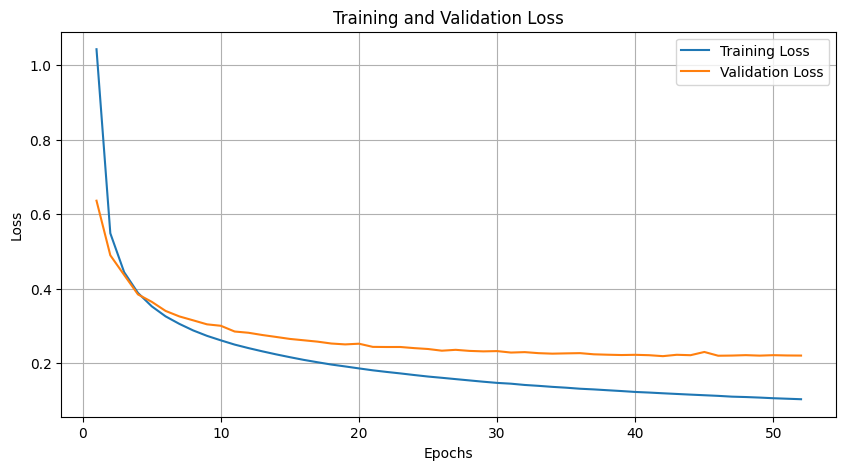

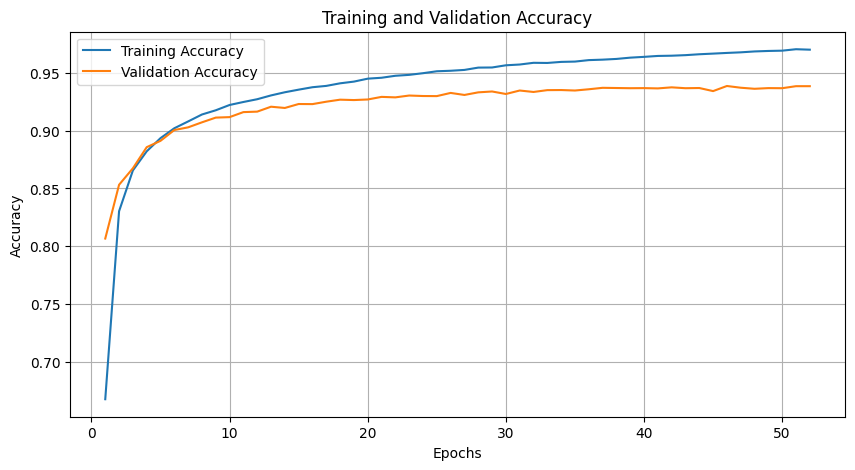

In [41]:
# Plotting
epochs = range(1, len(losses) + 1)

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
test_loss,test_acc = evaluate_test_set(final_net,test_images_flattened,test_labels,Categorical_Cross_Entropy_Loss)
val_loss,val_acc = evaluate_test_set(final_net,validation_images,validation_labels,Categorical_Cross_Entropy_Loss)

In [52]:
print("Test Set Stats:")
print(f"Loss: {np.mean(test_loss):.4f}, Accuracy: {np.mean(test_acc):.4f}")

print("\nValidation Set Stats:")
print(f"Loss: {np.mean(val_loss):.4f}, Accuracy: {np.mean(val_acc):.4f}")

Test Set Stats:
Loss: 0.2136, Accuracy: 0.9400

Validation Set Stats:
Loss: 0.2205, Accuracy: 0.9384


In [53]:
def create_confusion_matrix(actual, predicted, num_classes):
    """
    Generate a confusion matrix.

    Args:
    actual (numpy.ndarray): Array of true labels.
    predicted (numpy.ndarray): Array of predicted labels.
    num_classes (int): Number of classes.

    Returns:
    numpy.ndarray: Confusion matrix.
    """
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for a, p in zip(actual, predicted):
        matrix[int(a)][int(p)] += 1
    return matrix

def print_confusion_matrix(matrix):
    """
    Print the confusion matrix in a readable format with class numbers and separators using pandas DataFrame.

    Args:
    matrix (numpy.ndarray): Confusion matrix.

    Returns:
    None
    """
    num_classes = len(matrix)
    # Create DataFrame with class numbers as index and columns
    df = pd.DataFrame(matrix, index=[f"Actual {i}" for i in range(num_classes)], columns=[f"Predicted {i}" for i in range(num_classes)])
    print("Confusion Matrix:")
    display(df)

In [55]:
test_c = predict(final_net,test_images_flattened)

confusion_matrix = create_confusion_matrix(test_labels,test_c,10)

print_confusion_matrix(confusion_matrix)


Confusion Matrix:


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,951,0,7,2,0,8,5,4,2,1
Actual 1,0,1119,2,3,1,2,2,2,4,0
Actual 2,6,2,975,14,5,1,7,7,12,3
Actual 3,2,0,19,937,0,18,1,10,16,7
Actual 4,2,1,7,0,915,0,11,4,5,37
Actual 5,9,1,0,25,6,821,9,4,8,9
Actual 6,11,4,9,2,9,12,907,1,3,0
Actual 7,2,9,16,11,4,0,1,961,1,23
Actual 8,14,6,9,15,4,16,13,8,882,7
Actual 9,8,8,2,12,21,5,0,13,8,932


# Optimization

In [46]:
# hyper_parameters = {
#     "lr": [0.005],
#     "max_epochs": 80,
#     "batch_size": 128,
#     "h_layer_struct": [[8, 8], [16, 16], [24, 24], [32, 32]]
# }

# opt_stats = nested_k_fold(inputs = train_images_flattened,labels = train_labels, base_config= Network_Config(784,[],10,Activation_Sigmoid,Activation_SoftMax,Gaussian_Init), hyper_params= hyper_parameters)

# print_statistics(opt_stats)